<a href="https://colab.research.google.com/github/pedromazim/visao/blob/main/project_fractal_dimension_texture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Fractals and fractal dimension

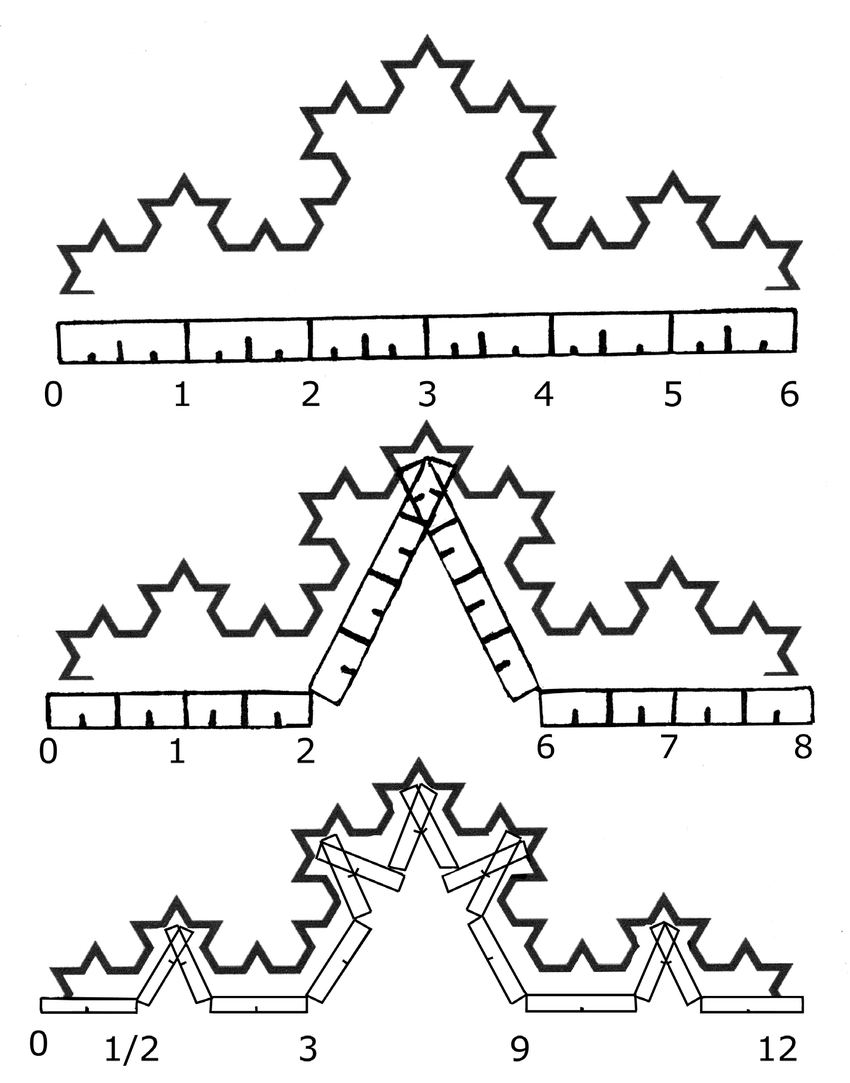

### I. Modules and auxiliary functions

In [ ]:
import numpy as np
import skimage as skm
import matplotlib.pyplot as pt
import matplotlib.colors as cm
import os
from glob import glob
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [ ]:
@jit(looplift=True)
def find_divisors(num):# finds common divisors :)
    d = []
    for i in range(2,int(num/2)+1):
        if num%i == 0:
            d.append(i)
    d.append(num)
    return np.array(d)

In [ ]:
# @jit(looplift=True)
def edt(img):
    # euclidean distance from foreground (white) to background (black) pixels

    img = img.astype('int')
    h, w = img.shape

    d = np.zeros((h,w))

    for y in range(h):
        for x in range(w):

            if img[x,y] == 1:
                flag = True
                r = 1
                while flag:
                    nb = img[x-r:x+r+1,y-r:y+r+1]
                    if np.flatnonzero(nb).size != nb.size:
                        d[x,y] = r
                        flag = False
                    else:
                        r += 1
    return d

In [ ]:
# @jit(looplift=True)
def distance(img, x0, y0):# distance from all foreground pixels to a specific one
    img = img.astype('int')
    h, w = img.shape
    dist = np.zeros_like(img)
    fg = np.argwhere(img == 1)
    dist = np.sqrt((np.indices((h,w))[0]-x0)**2 + (np.indices((h,w))[1]-y0)**2)
    return dist

In [ ]:
def make_square(img):

    h, w = img.shape # height, width

    if w > h:
        if w%2 != 0:
            img = np.column_stack((img, np.ones((h,1))*255))
            img = np.vstack((img, np.ones((w+1-h,w+1))*255))
        else:
            img = np.vstack((img, np.ones((w-h,w))*255))
    elif h > w:
        if h%2 != 0:
            img = np.vstack((img, np.ones((1,w))*255))
            img = np.column_stack((img, np.ones((h+1,h+1-w))*255))
        else:
            img = np.column_stack((img, np.ones((h,h-w))*255))
    return img


### II. Acquiring the dataset

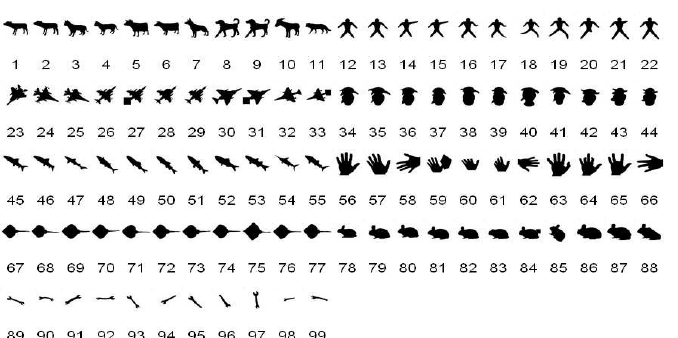

In [ ]:
!git clone https://github.com/pedromazim/visao.git

In [ ]:
%cd visao/shapes99/
os.getcwd()

In [ ]:
filename_list = sorted(glob("*.png"))

### III. Mass-radius method

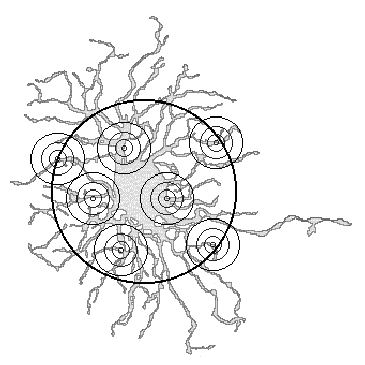

In [ ]:
def mrm(img):
    area = (np.argwhere(img == 1).size/2)
    cm = [int(1/area*np.sum(np.where(img == 1)[0])), int(1/area*(np.sum(np.where(img == 1)[1])))]
    rmax = int(np.max(distance(img,cm[0],cm[1])))

    counts = []
    size = []

    for r in range(1,rmax+1):
        c = 0
        for px in np.argwhere(distance(img, cm[0],cm[1]) <= r):
            if img[px[0],px[1]] == 1:
                c += 1
        if c != 0:
            size.append(r)
            counts.append(c)

    return counts,size

In [ ]:
def fd_dataset_mrm(filename_list): #calculates BCM and BMM for each image in dataset

    out = open('out_shapes_mrm.dat','w')

    MRM_fd = []

    for filename in range(len(filename_list)):
        #print(filename)
        img = skm.io.imread(f'https://github.com/pedromazim/visao/blob/main/shapes99/{filename_list[filename]}?raw=true')
        img = make_square(img)
        img = img/255.
        img = skm.util.invert(img)
        img = img == 1
        img.astype('int')

        mrm_fd = mrm(img)
        print(filename, filename_list[filename], 'mrm')

        out.write(f'{mrm_fd}\n')
        MRM_fd.append(mrm_fd)

    #data = np.savetxt('out_shapes.dat', np.array(BCM_fd))
    out = {'filename':filename_list, 'MRM_FD':MRM_fd}
    return out

In [ ]:
out_test_mrm = fd_dataset_mrm(filename_list)

In [ ]:
# linear regression for all images
lm_coeffs_MRM = []
for i in range(len(out_test_mrm['MRM_FD'])):
    counts, sizes= out_test_mrm['MRM_FD'][i][1][:-30],out_test_mrm['MRM_FD'][i][0][:-30]
    # print(counts,sizes)
    lm_coeffs_MRM.append(np.polyfit(np.log(sizes),np.log(counts),1)[0])

### IV. Box-counting method


download.svg

In [ ]:
#@jit(looplift=True)
def bcm(img, binary):
    if not binary:
        img = make_gray(img,[1/3,1/3,1/3])
        #thd = otsu_thresholding(img)
        thd = threshold_otsu(img)
        img = img > thd

        img = img.astype('int')

    img = skm.util.invert(img)

    grid = np.zeros_like(img)
    h, w = img.shape
    counts = []
    size = []

    res = 100


    for L in find_divisors(h):
        size.append(int(h/L))
        counter = 0
        for m in range(L):# loop for height
            for n in range(L):#loop for width
                if img[int(m*h/L):int((m+1)*h/L),int(n*w/L):int((n+1)*w/L)].any() == 1:
                    counter += 1
        counts.append(counter)

    return [counts, size]

In [ ]:
def fd_dataset_bcm(filename_list): #calculates BCM and BMM for each image in dataset

    out = open('out_shapes_bcm.dat','w')

    BCM_fd = []

    for filename in range(len(filename_list)):
        #print(filename)
        img = skm.io.imread(f'https://github.com/pedromazim/visao/blob/main/shapes99/{filename_list[filename]}?raw=true')
        img = make_square(img)
        img = img/255.
        img = skm.util.invert(img)
        img = img == 1
        img.astype('int')

        bcm_fd = bcm(img, True)
        # print(filename, filename_list[filename], 'bcm')

        out.write(f'{bcm_fd}\n')
        BCM_fd.append(bcm_fd)

    #data = np.savetxt('out_shapes.dat', np.array(BCM_fd))
    out = {'filename':filename_list, 'BCM_FD':BCM_fd}
    return out

In [ ]:
out_test_bcm = fd_dataset_bcm(filename_list)

In [ ]:
lm_coeffs_BCM = []
for i in range(len(out_test_bcm['BCM_FD'])):
    counts, sizes = out_test_bcm['BCM_FD'][i][0],out_test_bcm['BCM_FD'][i][1]
    # print(counts,sizes)
    lm_coeffs_BCM.append(np.polyfit(np.log(sizes),np.log(counts),1)[0])
lm_coeffs_BCM = np.array(lm_coeffs_BCM)*(-1)

### V. Bouligand-Minkowsky method

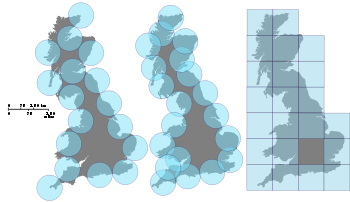

In [ ]:
def bmm(img, R):

    dt = edt(img)
    edge = np.argwhere(dt==1)
    counts = []
    fg = np.argwhere(img == 1)
    for r in range(1,R+1,10):# calculates influence area for multiple r values
        c = 0
        for e in edge:
            np.argwhere(distance(img, e[0],e[1]) <= r) # all pixels inside circle
            a = set((tuple(i) for i in np.argwhere(distance(img, e[0],e[1]) <= r)))
            b = set((tuple(i) for i in fg))
            c = len(a.intersection(b))

        counts.append(c)

    return counts

In [ ]:
#@jit(looplift=True)
def fd_dataset_bmm(filename_list): #calculates BCM and BMM for each image in dataset

    out = open('out_shapes_bmm.dat','w')

    BMM_fd = []

    for filename in range(len(filename_list)):
        #print(filename)
        img = skm.io.imread(f'https://github.com/pedromazim/visao/blob/main/shapes99/{filename_list[filename]}?raw=true')
        img = make_square(img)
        img = img/255.
        img = skm.util.invert(img)
        img = img == 1
        img.astype('int')
        print('pelo menos daqui passei')
        bmm_fd = bmm(img, 100)
        print(filename, filename_list[filename], 'bmm')

        out.write(f'{bmm_fd}\n')
        BMM_fd.append(bmm_fd)

    #data = np.savetxt('out_shapes.dat', np.array(BCM_fd))
    out = {'filename':filename_list, 'BMM_FD':BMM_fd}
    return out

In [ ]:
out_test_bmm = fd_dataset_bmm(filename_list)

In [ ]:
lm_coeffs_BMM = []
for i in range(len(out_test_bmm['BMM_FD'])):
    counts= np.transpose(out_test_bmm['BMM_FD'][i])
    # print(counts,sizes)
    lm_coeffs_BMM.append(np.polyfit(np.log(np.arange(1,101,10)),np.log(counts),1)[0])
lm_coeffs_BMM = 2 - np.array(lm_coeffs_BMM)

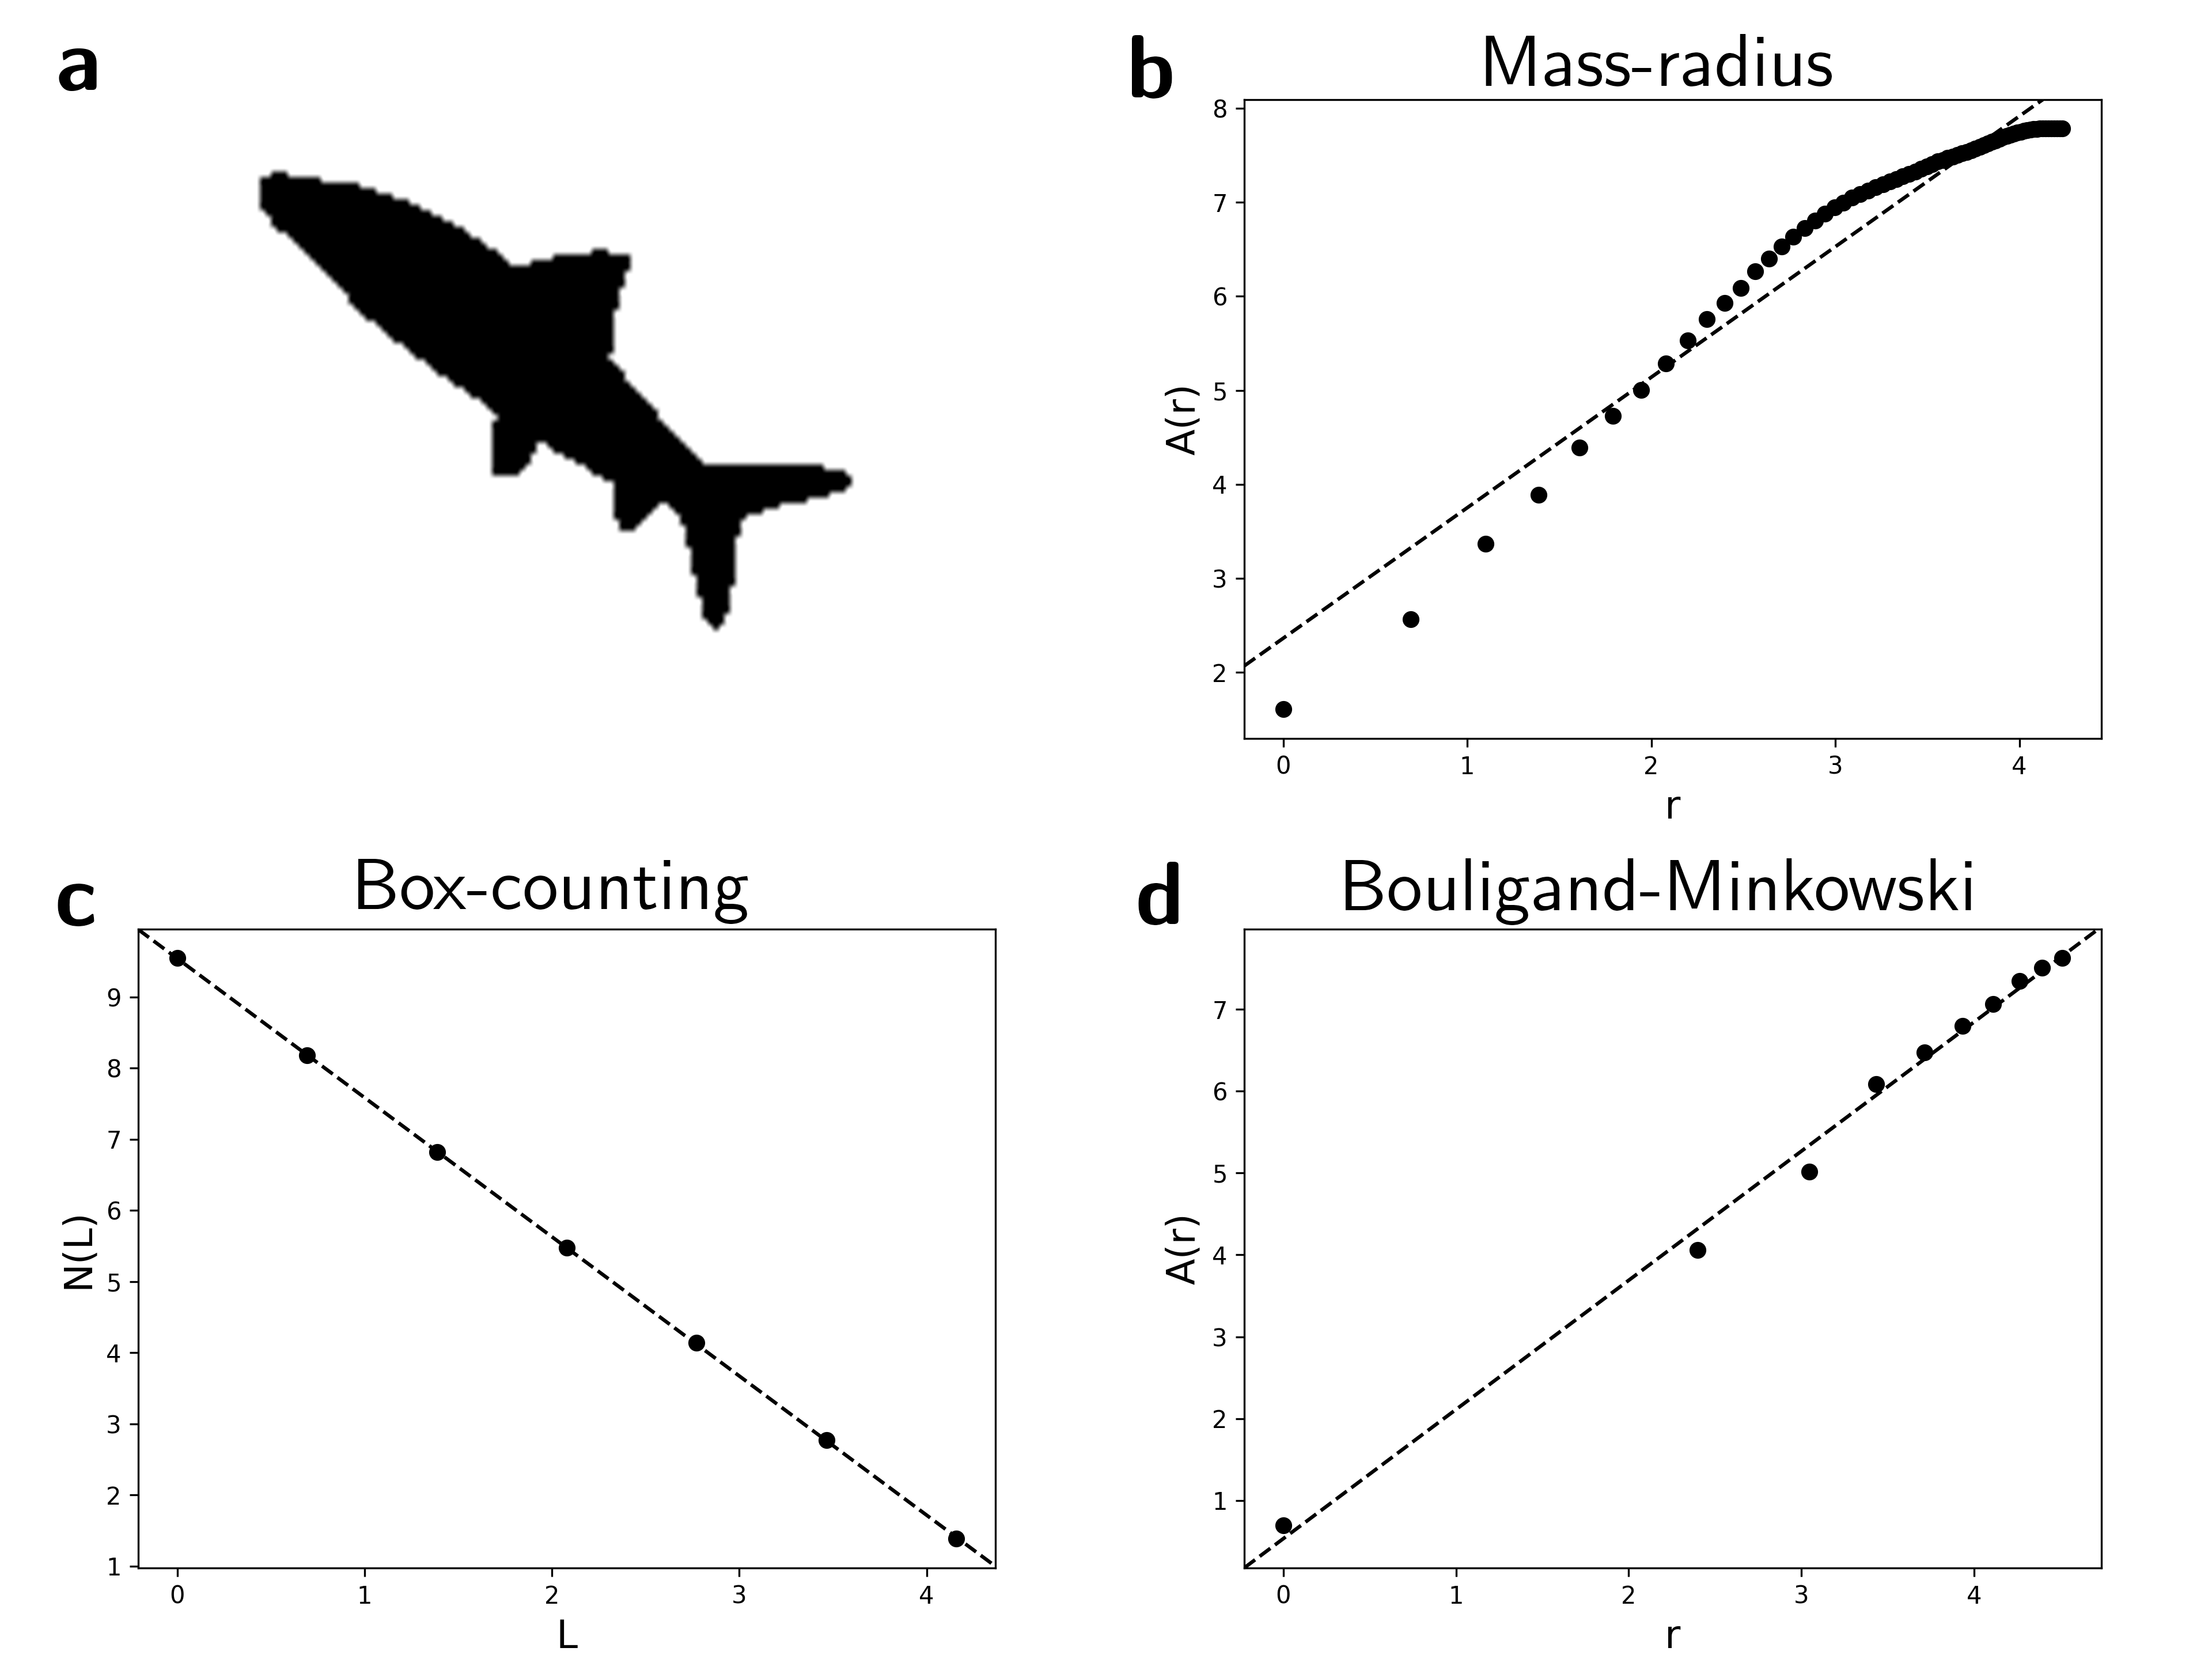

### VI. Additional measurements

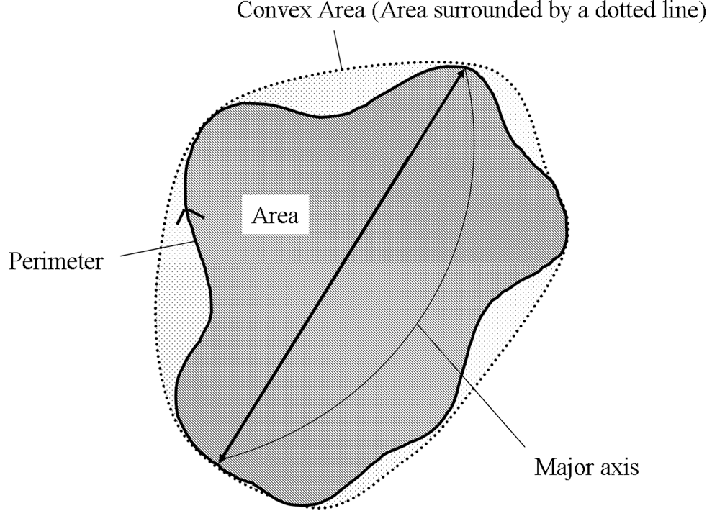

In [ ]:
def img_perimeter(filename_list):

    P = []

    for filename in range(len(filename_list)):
        #print(filename)
        img = skm.io.imread(f'https://github.com/pedromazim/visao/blob/main/shapes99/{filename_list[filename]}?raw=true')
        img = make_square(img)
        img = img/255.
        img = skm.util.invert(img)
        img = img == 1
        img.astype('int')

        p = np.argwhere(edt(img) == 1).size/2
        P.append(p)

    return P

In [ ]:
def img_area(filename_list):

    A = []

    for filename in range(len(filename_list)):
        #print(filename)
        img = skm.io.imread(f'https://github.com/pedromazim/visao/blob/main/shapes99/{filename_list[filename]}?raw=true')
        img = make_square(img)
        img = img/255.
        img = skm.util.invert(img)
        img = img == 1
        img.astype('int')

        a = np.argwhere(img == 1).size/2
        A.append(a)

    return A

Solidity = Image area / Convex hull area

prop-solidity.svg

In [ ]:
def img_solidity(filename_list):

    S = []

    for filename in range(len(filename_list)):
        #print(filename)
        img = skm.io.imread(f'https://github.com/pedromazim/visao/blob/main/shapes99/{filename_list[filename]}?raw=true')
        img = make_square(img)
        img = img/255.
        img = skm.util.invert(img)
        img = img == 1
        img.astype('int')

        ch = skm.morphology.convex_hull_image(img)
        s = np.argwhere(img==1).size/(2*ch.size)
        S.append(s)

    return S

In [ ]:
perimeter = img_perimeter(filename_list)

In [ ]:
area = img_area(filename_list)

In [ ]:
solidity = img_solidity(filename_list)

### VII. Classifying shapes by Principal Component Analysis (PCA)

In [ ]:
filenames = ['fish','fish','rabbit','animal','animal','animal','animal','animal','animal','rabbit','animal','animal','animal','fish','animal','dude','dude','dude','dude','dude','dude','dude','dude','dude','dude','dude','rabbit','plane','plane','plane','goblin','goblin','goblin','goblin','goblin','goblin','goblin','goblin','fish','fish','fish','fish','animal','hand','hand','hand','hand','hand','hand','hand','hand','hand','hand','hand','plane','plane','plane','plane','fish','ray','ray','ray','ray','ray','ray','ray','ray','ray','ray','ray','rabbit','goblin','goblin','goblin','rabbit','rabbit','rabbit','rabbit','fish','plane','plane','rabbit','plane','plane','rabbit','rabbit','fish','tool','tool','tool','tool','tool','tool','tool','tool','tool','tool','tool','fish']

In [ ]:
df = pd.DataFrame({'filenames':filenames, 'lm_coeffs_MRM':lm_coeffs_MRM, 'lm_coeffs_BCM':lm_coeffs_BCM, 'lm_coeffs_BMM':lm_coeffs_BMM, 'perimeter':perimeter, 'area':area, 'solidity':solidity})

In [ ]:
df

In [ ]:
targets = ['tool', 'dude', 'fish' , 'rabbit', 'ray', 'animal', 'plane', 'hand', 'goblin']
features = ['lm_coeffs_BMM', 'solidity']

# Separating out the features
x = df.loc[:, features].values

# Separating out the target
y = df.loc[:,['filenames']].values

# Standardizing the features
x = StandardScaler().fit_transform(x)

pca = PCA(n_components=2)

principalComponents = pca.fit_transform(x)

principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

finalDf = pd.concat([principalDf, df[['filenames']]], axis = 1)

fig = pt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)

targets = ['tool', 'dude', 'fish' , 'rabbit', 'ray', 'animal', 'plane', 'hand', 'goblin']
colors = ['r', 'g', 'b', 'k', 'orange', 'm', 'c', 'y', 'gray']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['filenames'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

# pt.savefig('PCA_test_bmm_3.png', dpi=300)
# pt.show()

Clustering using perimeter

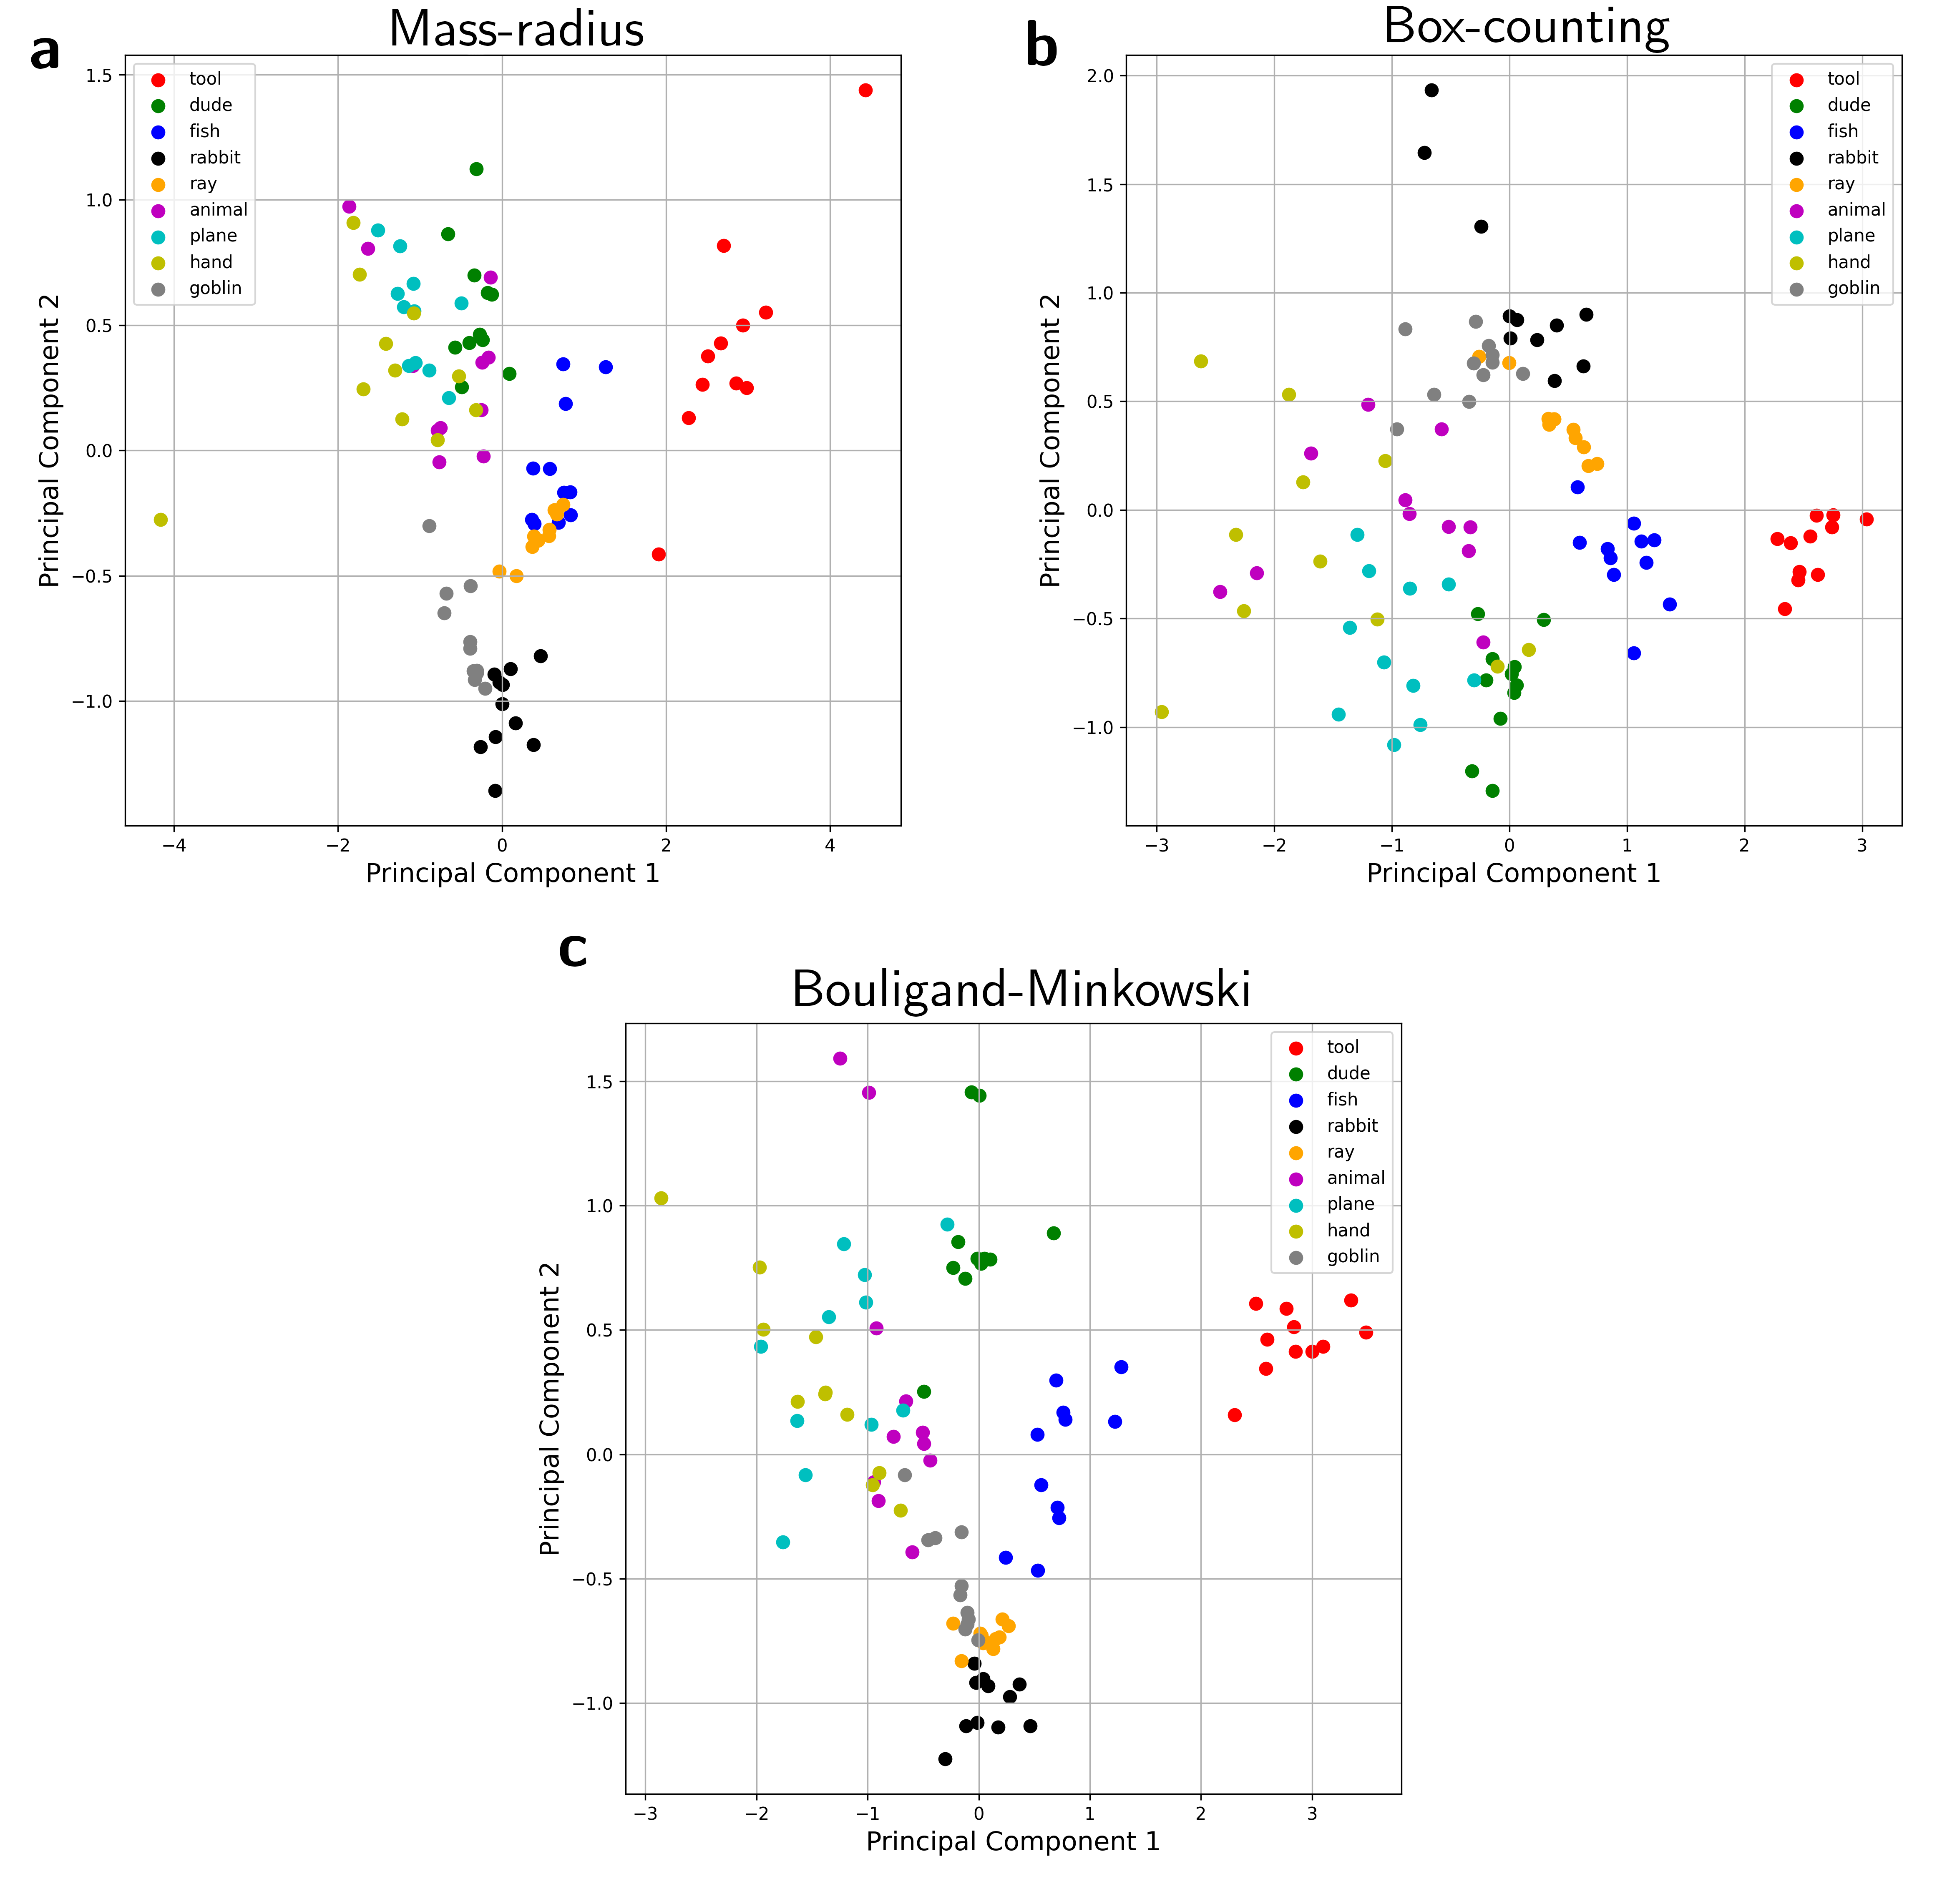

Clustering using area

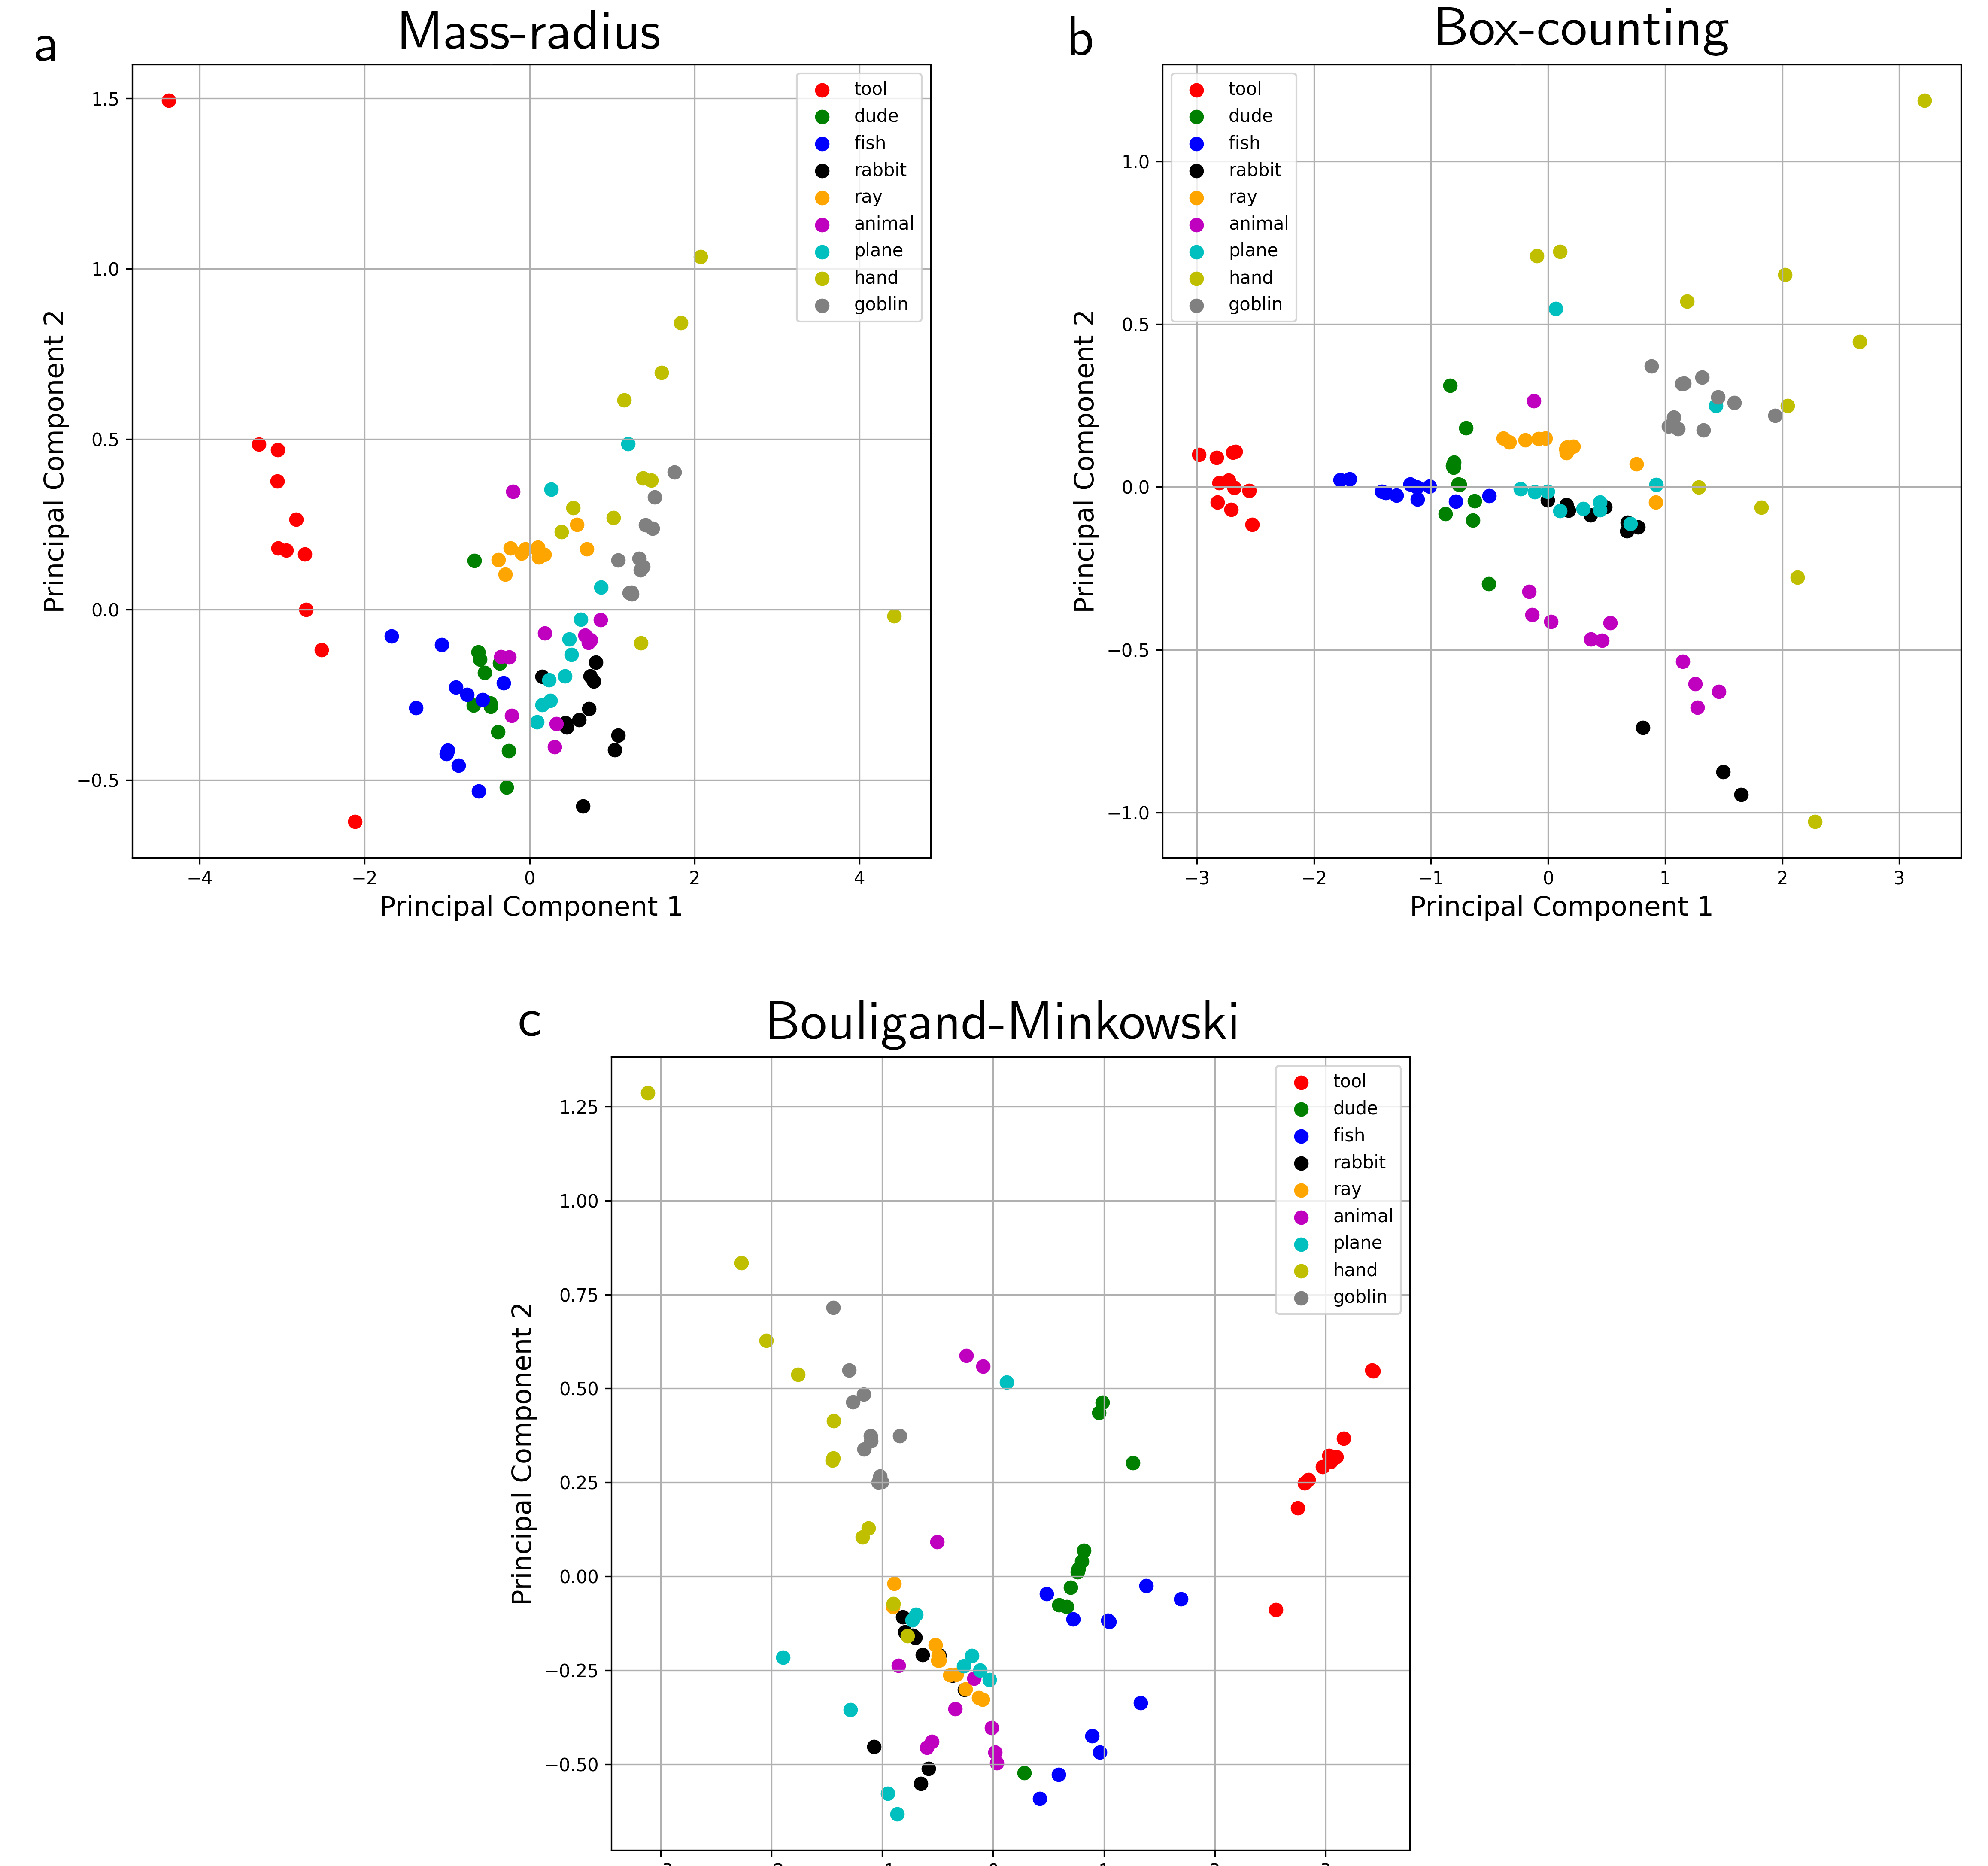

Clustering using solidity

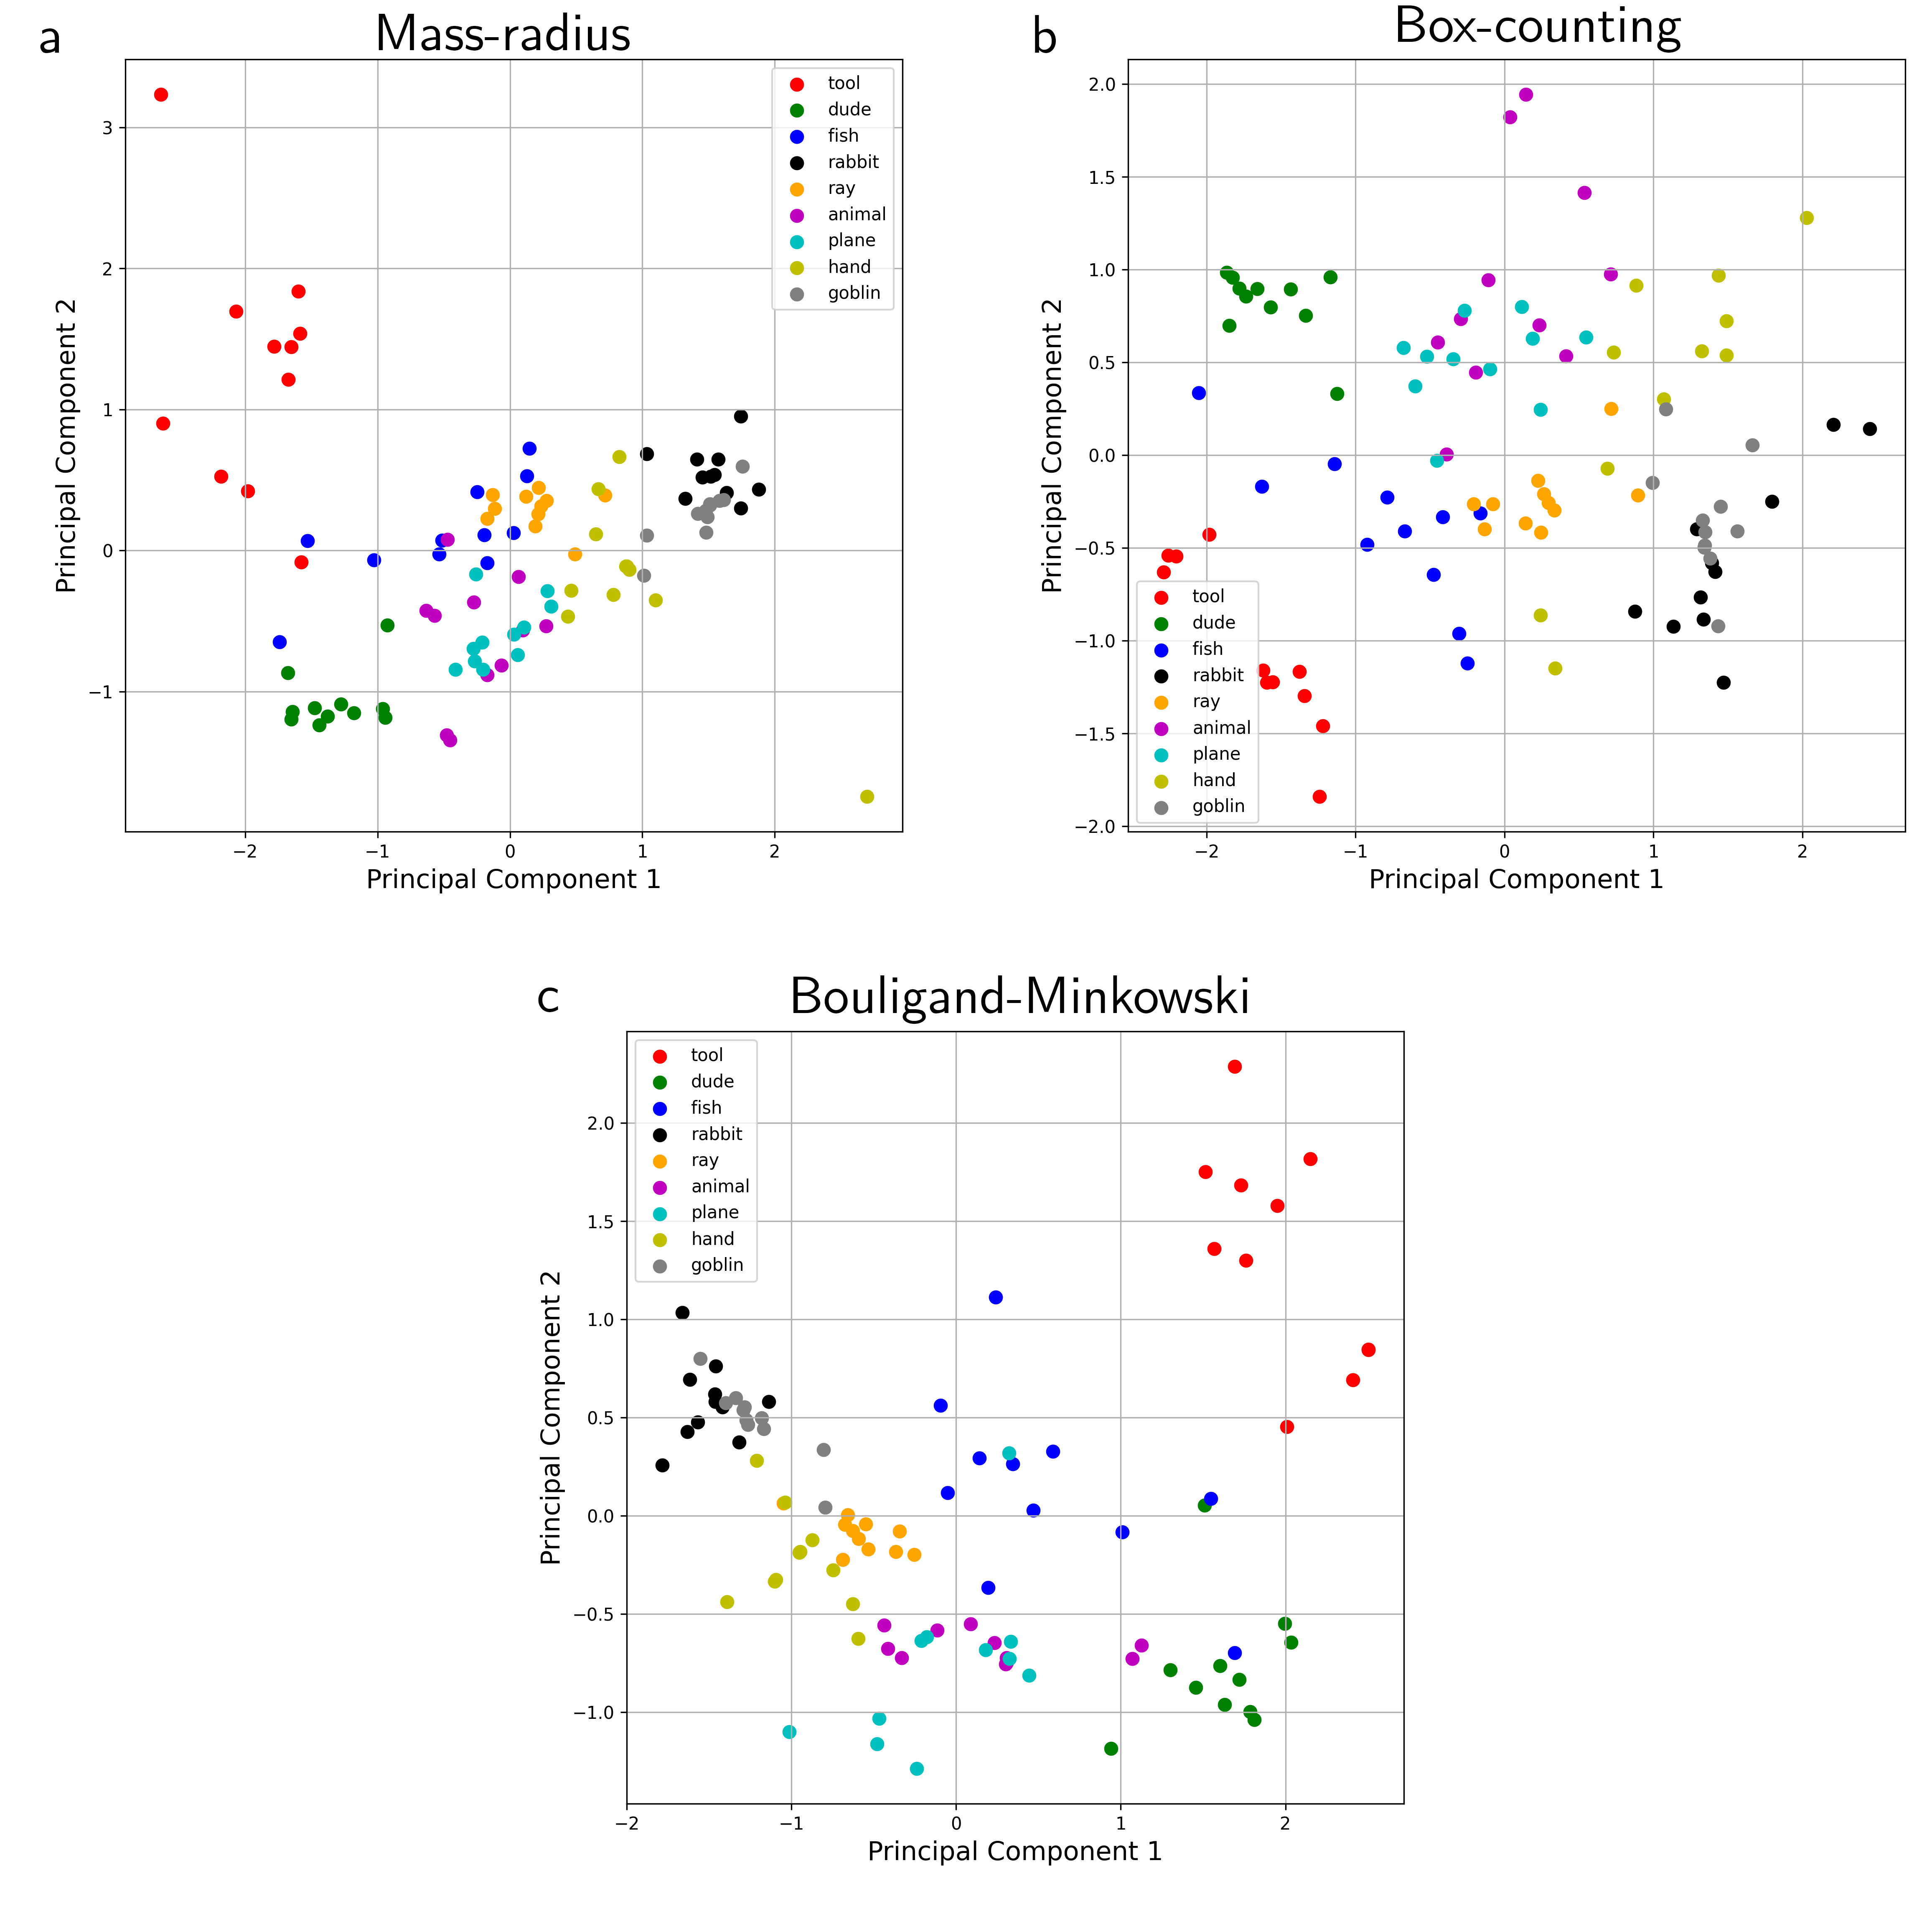